![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+GenAI&dt=Getting+Started+-+Vertex+AI+GenAI+Python+Client.ipynb)

# Getting Started - Vertex AI GenAI Python Client

How to get information into (prompts) and out of (responses) of Vertex AI hosted Generative AI Models!


Vertex AI has access to hosted [generative AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) models, called foundation models.  These can be easily interacted with in the console using [Vertex AI Generative AI Studio](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/generative-ai-studio).  This notebook covers interacting with the models with the [vertexai](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai) Python package that is include with the Vertex AI SDK [aiplatform](https://cloud.google.com/python/docs/reference/aiplatform/latest).

The current models in GA and in preview can be reviewed in the [documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/models) as well as within the [Vertex AI Model Garden](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/model-garden) which also include access to serving and tuning OSS models.

Model have names and versions.  The [names](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/models#model_naming_scheme) are designed show both the purpose and size of the model.  For instance, sizes are conveyed with names like `Bison` and `Gecko` while purposes are `text`, `textembedding`, `chat`, `code`, `imagetext`, `imagegeneration` and more.  [Versions](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/model-versioning)  are either `stable` and available for six months after the release of subsequent version, or `latest` which are incremenatally updated and improved but can give different responses to the same prompt.

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Getting%20Started%20-%20Vertex%20AI%20GenAI%20Python%20Client.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [1]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [2]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [126]:
REGION = 'us-central1'
SERIES = 'applied-genai'
EXPERIMENT = 'getting-started'

In [131]:
# Set the BUCKET name for saving work:
BUCKET = PROJECT_ID

In [457]:
from google.cloud import aiplatform
from google.cloud import storage
import vertexai.language_models

import json
import requests

In [6]:
aiplatform.__version__

'1.35.0'

In [130]:
vertexai.init(project = PROJECT_ID, location = REGION)
gcs = storage.Client(project = PROJECT_ID)

In [132]:
bucket = gcs.lookup_bucket(BUCKET)

---
## Vertex AI Package

With the [vertexai](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai) client there are packages for the types of data being interacted with.  There is also a higher package for preview models (not yet in GA):

Language Models:
- [vertexai.language_models](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai#language_models)
    - [vertexai.preview.language_models()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview#language_models)

Vision Models:
- [vertexai.vision_models](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai#vision_models)
    - [vertexai.preview.vision_models()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview#vision_models)


---
## Language Models

Interacting with language models with the `vertexai` client is done through methods based on the type of model and interaction:
- [vertexai.language_models.TextGenerationModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.TextGenerationModel)
- [vertexai.language_models.TextEmbedding()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.TextEmbedding)
- [vertexai.language_models.ChatModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.ChatModel)
- [vertexai.language_models.CodeChatModel](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.CodeChatModel)
- [vertexai.language_models.CodeGenerationModel](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.CodeGenerationModel)

These methods are followed with methods to retrieve either:
- hosted models on Vertex AI with `.from_pretrained(model_name = str)`
- or, in cases where tuning is possible and has been conducted, `.get_tuned_model(tuned_model_name = str)`

In [8]:
import vertexai.language_models

### Text Generation

This is the main thing we think about with generative AI. Ask a quesiton in a prompt and get a response.  

- [vertexai.language_models.TextGenerationModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.TextGenerationModel)

In [154]:
model = vertexai.language_models.TextGenerationModel.from_pretrained('text-bison@latest')

In [92]:
prompt = "What is the first paragraph of the book A Tale of Two Cities?"

In [93]:
response = model.predict(prompt)
response

 It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, it was the epoch of belief, it was the epoch of incredulity, it was the season of Light, it was the season of Darkness, it was the spring of hope, it was the winter of despair, we had everything before us, we had nothing before us, we were all going direct to Heaven, we were all going direct the other way—in short, the period was so far like the present period, that some of its noisiest authorities insisted on its being received, for

#### Parameters

The prediction request can include parameters:
- max_output_tokens = upper limit for amount of text in the response
- temperature = [0, 1] value that control the randomness of token selection where 0 always selects the most likely next token and 1 is the highest level or randomness is selection from available tokens controlled by `top_k` and `top_p`
- top_k = an integer that limits the number of token considered in the selection of the next token
- top_p = a value in [0,1] that sets sum of probabilities from which the list of candidate tokens is selected from where the token probabilities are ordered from largest to smallest
- stop_sequences = a list of up to five character strings that will stop response generation
- candidate_count = number of candidate responses to consider

In [94]:
response = model.predict(
    prompt, 
    max_output_tokens = 200, 
    temperature = .4, 
    top_k = 10, 
    top_p = .5, 
    stop_sequences = ['noisiest authorities'], 
    candidate_count = 1)
response

 It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, it was the epoch of belief, it was the epoch of incredulity, it was the season of Light, it was the season of Darkness, it was the spring of hope, it was the winter of despair, we had everything before us, we had nothing before us, we were all going direct to Heaven, we were all going direct the other way—in short, the period was so far like the present period, that some of its 

Notice that the response is shorter.  In this case not because the limit of `max_output_tokens` but because the `stop_sequence` ended the response when it encountered the phrase 'noisiest authorities'.  Also, the impact of `temperature`, `top_k` and `top_p` where minimized because the response is a know value from a popular literary work.

The response actually include information for understancing it type and potential source.  In this case the response is, as requested, a direct qoute from a popular work.  Additional parameters are found in the response which is an object of type [TextGenerationResponse()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.TextGenerationResponse).

#### TextGenerationResponse

In [95]:
type(response)

vertexai.language_models.MultiCandidateTextGenerationResponse

In [96]:
response._prediction_response.predictions[0]

{'safetyAttributes': {'scores': [0.6],
  'categories': ['Religion & Belief'],
  'blocked': False},
 'citationMetadata': {'citations': [{'startIndex': 1.0,
    'endIndex': 491.0,
    'url': 'https://nn.wikipedia.org/wiki/Engelsk_litteratur'}]},
 'content': ' It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, it was the epoch of belief, it was the epoch of incredulity, it was the season of Light, it was the season of Darkness, it was the spring of hope, it was the winter of despair, we had everything before us, we had nothing before us, we were all going direct to Heaven, we were all going direct the other way—in short, the period was so far like the present period, that some of its '}

#### Async Prediction

The client has built a method for awaitable responses that make it easy to make asynchronous request.

To see an example of using this for making asynchronous calls check out the [Async Predictions In Use](#async) section later in the notebook.

In [97]:
response = await model.predict_async(prompt)
response

 It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, it was the epoch of belief, it was the epoch of incredulity, it was the season of Light, it was the season of Darkness, it was the spring of hope, it was the winter of despair, we had everything before us, we had nothing before us, we were all going direct to Heaven, we were all going direct the other way—in short, the period was so far like the present period, that some of its noisiest authorities insisted on its being received, for

#### Streaming Prediction

The client has a built in method for streaming responses that return a generator that can be iterated:

In [98]:
for r in model.predict_streaming(prompt):
    print(r)

 It was the best of times, it was the worst of times, it was the
 age of wisdom, it was the age of foolishness, it was the epoch 
of belief, it was the epoch of incredulity, it was the season of
 Light, it was the season of Darkness, it was the spring of hope
, it was the winter of despair, we had everything before us, we 
had nothing before us, we were all going direct to Heaven, we we
re all going direct the other way—in short, the period was so fa
r like the present period, that some of its noisiest authorities
 insisted on its being received, for good or for evil, in the su
perlative degree of comparison only.


#### Batch Prediction

For workflows that need to batch predict response for sets of prompts on a schedule or periodically, the [.batch_predict()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.TextGenerationModel#vertexai_language_models_TextGenerationModel_batch_predict) method can be used to submit sets for prediction as a job.

The source/destination can either be a GCS bucket or a BigQuery table.  

Here we store JSONL in GCS and use it as the source/destination location.

Start with a list of prompts:

In [140]:
prompts = [
    'What is the first paragraph of the book A Tale of Two Cities?',
    'What is the first sentence of the book A Tale of Two Cities?'
]

Convert the prompts to newline delimited JSONL:

In [141]:
batch = '\n'.join(map(json.dumps, [dict(prompt = prompt) for prompt in prompts]))

In [142]:
print(batch)

{"prompt": "What is the first paragraph of the book A Tale of Two Cities?"}
{"prompt": "What is the first sentence of the book A Tale of Two Cities?"}


Store the JSONL in GCS as the source location:

In [143]:
blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/textgen/batch_input.jsonl')
blob.upload_from_string(batch)

Request the batch prediction job:

In [160]:
#batch_job = model.batch_predict(
#    dataset = f'gs://{BUCKET}/{blob.name}',
#    destination_uri_prefix = f'gs://{BUCKET}/{SERIES}/{EXPERIMENT}/textgen/results'
#)

### Chat

Chat is an extension of text generation where there is a session in which the back and forth create a cumulative context from which future questions frame answers around.

- [vertexai.language_models.ChatModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.ChatModel)

In [99]:
model = vertexai.language_models.ChatModel.from_pretrained('chat-bison@latest')

In [100]:
chat = model.start_chat(
    context = 'You are an umpire for Major League Baseball in the United States.',
    examples = [
        vertexai.language_models.InputOutputTextPair(
            input_text = 'How many players are allowed in the outfield?',
            output_text = 'There are only three players allowed in the outfield: left fielder, center fielder, and right fielder.'
        )
    ]
)

In [101]:
response = chat.send_message('How many bases are there?')
response

 There are only four bases on a baseball field: home plate, first base, second base, and third base. 

In [102]:
response = chat.send_message('Four? What are they called?')
response

 Home plate, first base, second base, and third base.

In [103]:
response = chat.send_message('So home plate is a base?')
response

 Yes, home plate is considered a base.


#### Chat Session

As the chat progresses it is collected in a chat session:

In [104]:
type(chat)

vertexai.language_models.ChatSession

To review the chat transcript view the `message_history` property:

In [105]:
chat.message_history

[ChatMessage(content='How many bases are there?', author='user'),
 ChatMessage(content=' There are only four bases on a baseball field: home plate, first base, second base, and third base. ', author='bot'),
 ChatMessage(content='Four? What are they called?', author='user'),
 ChatMessage(content=' Home plate, first base, second base, and third base.', author='bot'),
 ChatMessage(content='So home plate is a base?', author='user'),
 ChatMessage(content=' Yes, home plate is considered a base.\n', author='bot')]

### Text Embedding

An LLM that efficiently represent text as a vector of numbers.  This is great for finding similar text (search), place unkown text near matches in know grouping (classification), group text together (clustering), identifying mismatching text (anomalies and outliers), finding patterns in conversation (topic labeling), and much more.

- [vertexai.language_models.TextEmbeddingModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.TextEmbeddingModel)

In [107]:
model = vertexai.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@latest')

In [108]:
prompt = "This is a string of text representing something!"

Notice that the prompt is provided in a list because multiple prompts can be sent in a single request.  If the list identifier brackets, `[]`, are missing then an error will be returned due to it treat each character of a string as a separate prompt string.

In [119]:
response = model.get_embeddings([prompt])

The response is also a list of same length as the the input prompts list. Here the first 5 values of the embedding is presented for review: 

In [122]:
len(response[0].values)

768

In [123]:
response[0].values[0:5]

[0.00302836112678051,
 -0.045257508754730225,
 0.011893450282514095,
 0.002171202329918742,
 0.08558599650859833]

#### Async Embeddings

The client has built a method for awaitable responses that make it easy to make asynchronous request.

To see an example of using this for making asynchronous calls check out the [Async Predictions In Use](#async) section later in the notebook.

In [124]:
response = await model.get_embeddings_async([prompt])

In [125]:
response[0].values[0:5]

[0.00302836112678051,
 -0.045257508754730225,
 0.011893450282514095,
 0.002171202329918742,
 0.08558599650859833]

### Code Generation

Generate code based on text prompts.

- [vertexai.language_models.CodeGenerationModel](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.CodeGenerationModel)

In [161]:
model = vertexai.language_models.CodeGenerationModel.from_pretrained('code-bison@latest')

In [167]:
prompt = 'Write a Python Function that calculate the probability of two people with the same birthday being in the same room given the number of people in the room as input.  Include code to run the function for up to 20 people.'

In [168]:
response = model.predict(prompt)
response

```python
import math

def birthday_probability(num_people):
  """Calculates the probability of two people in a room having the same birthday.

  Args:
    num_people: The number of people in the room.

  Returns:
    The probability of two people having the same birthday.
  """

  # Calculate the probability of two people not having the same birthday.
  probability = 1
  for i in range(1, num_people):
    probability *= (365 - i) / 365

  # Return the complement of the probability of two people not having the same birthday.
  return 1 - probability


# Run the function for up to 20 people.
for i in range(1, 21):
  print("The probability of two people in a room of {} people having the same birthday is {:.2f}%.".format(i, birthday_probability(i) * 100))
```

Remove the first and last lines from the response:

In [181]:
code = '\n'.join(response.text.splitlines()[1:-1])
print(code)

import math

def birthday_probability(n):
  """Calculates the probability of two people in a room of n people having the same birthday.

  Args:
    n: The number of people in the room.

  Returns:
    The probability of two people having the same birthday.
  """

  # The probability that two people have different birthdays is the product of the probabilities that each pair of people have different birthdays.
  # The probability that two people have the same birthday is 1 - the probability that they have different birthdays.

  probability = 1
  for i in range(1, n):
    probability *= (365 - i) / 365

  return 1 - probability


# Print the probability of two people having the same birthday for up to 20 people.

for i in range(1, 21):
  print(f"The probability of two people having the same birthday in a room of {i} people is {birthday_probability(i):.4f}.")


Try the code out!  Remove the first and last lines from the string and run the code with Python built in function `exec()`:

In [182]:
exec(code)

The probability of two people having the same birthday in a room of 1 people is 0.0000.
The probability of two people having the same birthday in a room of 2 people is 0.0027.
The probability of two people having the same birthday in a room of 3 people is 0.0082.
The probability of two people having the same birthday in a room of 4 people is 0.0164.
The probability of two people having the same birthday in a room of 5 people is 0.0271.
The probability of two people having the same birthday in a room of 6 people is 0.0405.
The probability of two people having the same birthday in a room of 7 people is 0.0562.
The probability of two people having the same birthday in a room of 8 people is 0.0743.
The probability of two people having the same birthday in a room of 9 people is 0.0946.
The probability of two people having the same birthday in a room of 10 people is 0.1169.
The probability of two people having the same birthday in a room of 11 people is 0.1411.
The probability of two people 

#### Async Prediction

The client has built a method for awaitable responses that make it easy to make asynchronous request.

To see an example of using this for making asynchronous calls check out the [Async Predictions In Use](#async) section later in the notebook.

In [178]:
response = await model.predict_async(prompt)

#### Streaming Prediction

The client has a built in method for streaming responses that return a generator that can be iterated:

In [179]:
for r in model.predict_streaming(prompt):
    print(r)

```python
import math

def birthday_probability(n):
  """Calcul
ates the probability of two people in a room of n people having 
the same birthday.

  Args:
    n: The number of people in the r
oom.

  Returns:
    The probability of two people having the sa
me birthday.
  """

  # The probability that two people have dif
ferent birthdays is the product of the 
  # probabilities that e
ach pair of people have different birthdays.
  # 
  # birthday_p
robability = (365! / (365-n)! / 365^n)
  #
  # Where ! denotes t
he factorial operation.  
  #
  # To avoid overflow, we use the 
following formula:
  #
  # birthday_probability = 1 - (365 * 364
 * ... * (365-n+1)) / 365^n
  #

  probability = 1.0
  for i in 
range(1, n):
    probability *= (365 - i) / 365.0

  return 1 - 
probability


# Print the probability for up to 23 people.
for i
 in range(1, 24):
  print("Probability of two people having the 
same birthday in a room of {} people: {:.6f}".format(i, birthday
_probability(i)))
```


### Code Generation - Completion

There are smaller models that are good for completing code.  This example show taking a portion of the code generate above as input and evaluates the models ability to complete the code:

- [vertexai.language_models.CodeGenerationModel](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.CodeGenerationModel)

In [180]:
model = vertexai.language_models.CodeGenerationModel.from_pretrained('code-gecko@latest')

In [195]:
prompt = '''#
# Python function to compare two string and return a list of all indexes where the strings are different:
def string_diffs(string1, string2):
'''

In [196]:
response = model.predict(prompt)
response

    diffs = []
    for i in range(len(string1)):
        if string1[i] != string2[i]:
            diffs.append(i)
    return diffs

In [207]:
code = prompt + response.text + "\nprint(string_diffs('abcdefghi', 'abcdfeghi'))"
print(code)

#
# Python function to compare two string and return a list of all indexes where the strings are different:
def string_diffs(string1, string2):
    diffs = []
    for i in range(len(string1)):
        if string1[i] != string2[i]:
            diffs.append(i)
    return diffs
print(string_diffs('abcdefghi', 'abcdfeghi'))


In [208]:
exec(code)

[4, 5]


### Code Chat

Chatting with code is great for documenting, adding comments, creating release notes, creating unit test, explaining, fixing, optimizing and even translating.

This example creates a chat session with the code generate from the prior section.

- [vertexai.language_models.CodeChatModel](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.CodeChatModel)

In [210]:
model = vertexai.language_models.CodeChatModel.from_pretrained('codechat-bison@latest')

Start a chat session with just the context and set it to the code generate in the prior section:

In [212]:
codechat = model.start_chat(context = code)

In [213]:
codechat.send_message('What does the code do?')

 The code you provided is a Python function that compares two strings and returns a list of all indexes where the strings are different. The function takes two strings as input, string1 and string2, and then uses a for loop to iterate over the indexes of the strings. For each index, the function checks if the characters at that index in the two strings are the same. If the characters are not the same, the function appends the index to the diffs list. Finally, the function returns the diffs list.

When you run the code, it will print the following output:

```
[1, 3]
```

This means that the two strings are different at indexes 1 and 3.

In [214]:
codechat.send_message('How would I change this code to handle input strings of different lengths?')

 To handle input strings of different lengths, you can use the following code:

```python
def string_diffs(string1, string2):
    diffs = []
    shorter_string = min(string1, string2, key=len)
    longer_string = max(string1, string2, key=len)
    for i in range(len(shorter_string)):
        if shorter_string[i] != longer_string[i]:
            diffs.append(i)
    return diffs
```

This code will work even if the two input strings are of different lengths. For example, if you run the code with the following input strings, it will print the following output:

```
string1 = "abcdefghi"
string2 = "abcd"

print(string_diffs(string1, string2))
```

Output:

```
[4, 5, 6, 7, 8]
```

This means that the two strings are different at indexes 4, 5, 6, 7, and 8.

In [215]:
codechat.send_message('Can you add commenting to this version that describes the steps?')

 ```python
def string_diffs(string1, string2):
    """
    Compare two strings and return a list of all indexes where the strings are different.

    Args:
        string1 (str): The first string to compare.
        string2 (str): The second string to compare.

    Returns:
        list: A list of all indexes where the strings are different.
    """

    # Find the shorter and longer strings.
    shorter_string = min(string1, string2, key=len)
    longer_string = max(string1, string2, key=len)

    # Create a list to store the differences.
    diffs = []

    # Iterate over the indexes of the shorter string.
    for i in range(len(shorter_string)):

        # Check if the characters at the current index are different.
        if shorter_string[i] != longer_string[i]:

            # Add the index to the list of differences.
            diffs.append(i)

    # Return the list of differences.
    return diffs
```

In [216]:
codechat.send_message('I plan to change to this new version, can you write release note for the change?')

 Version 1.1.0

**New Features**

* The string_diffs() function now handles input strings of different lengths.

**Bug Fixes**

* Fixed a bug where the string_diffs() function would return an empty list if the input strings were the same.

**Improvements**

* The string_diffs() function is now more efficient.

**Documentation**

* The documentation for the string_diffs() function has been updated to reflect the new features and bug fixes.

In [217]:
codechat.send_message('Can you write a unit test for this code?')

 ```python
import unittest

class TestStringDiffs(unittest.TestCase):

    def test_same_strings(self):
        string1 = "abcdefghi"
        string2 = "abcdefghi"
        diffs = string_diffs(string1, string2)
        self.assertEqual(diffs, [])

    def test_different_strings(self):
        string1 = "abcdefghi"
        string2 = "abcdfeghi"
        diffs = string_diffs(string1, string2)
        self.assertEqual(diffs, [1, 3])

    def test_different_lengths(self):
        string1 = "abcdefghi"
        string2 = "abcd"
        diffs = string_diffs(string1, string2)
        self.assertEqual(diffs, [4, 5, 6, 7, 8])

if __name__ == '__main__':
    unittest.main()
```

In [218]:
codechat.send_message('One last thing, can you write a javascript version of the new code?')

 ```javascript
function stringDiffs(string1, string2) {
  const diffs = [];
  const shorterString = string1.length < string2.length ? string1 : string2;
  const longerString = string1.length >= string2.length ? string1 : string2;
  for (let i = 0; i < shorterString.length; i++) {
    if (shorterString[i] !== longerString[i]) {
      diffs.push(i);
    }
  }
  return diffs;
}

console.log(stringDiffs('abcdefghi', 'abcdfeghi')); // [1, 3]
console.log(stringDiffs('abcdefghi', 'abcd')); // [4, 5, 6, 7, 8]
```

### Get Token Count

The text models have input and output limits that are based on the number of tokens. It can be helpful to get the token count for a prompt (or response).  This can be done with the CountTokens model.

> Note: This is still in preview and as of version 1.35.0 of the Python API (aiplatform) it is not yet implemented.  The following demonstrates using a REST call with the Python `requests` package.

- [Get Token Count](https://cloud.google.com/vertex-ai/docs/generative-ai/get-token-count)

In [319]:
MODEL_ID = 'text-bison'

In [320]:
len(prompt)

144

In [321]:
token = !gcloud auth application-default print-access-token
headers = {
    "content-type": "application/json",
    "Authorization": f'Bearer {token[0]}'
}

response = requests.post(
    f'https://{REGION}-aiplatform.googleapis.com/v1beta1/projects/{PROJECT_ID}/locations/{REGION}/publishers/google/models/{MODEL_ID}:countTokens',
    data = json.dumps(dict(instances = [dict(prompt = prompt)])),
    headers = headers
)

In [323]:
result = json.loads(response.text)
result

{'totalTokens': 35, 'totalBillableCharacters': 121}

---
## Vision Models

Interacting with vision models with the `vertexai` client is done through methods based on the type of model and interaction:
- [vertexai.vison_models.ImageCaptioningModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.vision_models.ImageCaptioningModel)
- [vertexai.vision_models.ImageQnAModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.vision_models.ImageQnAModel)
- [vertexai.vison_models.ImageTextModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.vision_models.ImageTextModel)
- [vertexai.vision_models.MultiModalEmbeddingModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.vision_models.MultiModalEmbeddingModel)
- preview:
    - [vertexai.preview.vision_models.ImageGenerationModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.vision_models.ImageGenerationModel)

In [222]:
import vertexai.vision_models

First, load an image.  This notebook comes from the GitHub repository [statmike/vertex-ai-mlops](https://github.com/statmike/vertex-ai-mlops/tree/main) which has graphical explanation of many ML and MLOps concepts.

For example:

<p align="center" width="100%" style="align:center;width:100%">
    <figure style="align:center;width:100%">
        <img src="https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/architectures/overview/decision.png" style="width:75%">
        <figcaption>https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/architectures/overview/decision.png</figcaption>
    </figure>
</p>

Images need to be loaded to the class [vertexai.vision_models.Image()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.vision_models.Image) as bytes.


In [229]:
url = 'https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/architectures/overview/decision.png'
image_bytes = requests.get(url).content

In [230]:
type(image_bytes)

bytes

In [236]:
image = vertexai.vision_models.Image(image_bytes = image_bytes)

### Image Captioning

Captioning, or describing, images using an image model.

- [vertexai.vison_models.ImageCaptioningModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.vision_models.ImageCaptioningModel)

In [241]:
model = vertexai.vision_models.ImageCaptioningModel.from_pretrained("imagetext@001")

In [244]:
captions = model.get_captions(image = image, language = 'en', number_of_results = 3)

In [245]:
captions

['a flow chart shows a choice between pre trained apis and bigquery ml',
 'a flowchart shows a choice between pre trained apis and bigquery ml',
 'a flow chart shows a choice between pre-trained apis and bigquery ml']

### Image Q&A

Answer questions with an iamge.

- [vertexai.vision_models.ImageQnAModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.vision_models.ImageQnAModel)

In [246]:
model = vertexai.vision_models.ImageQnAModel.from_pretrained("imagetext@001")

In [248]:
model.ask_question(image = image, question= 'What is this?')

['flowchart']

In [253]:
model.ask_question(image = image, question= 'How many steps are in the flowchart?')

['4']

In [254]:
model.ask_question(image = image, question= 'How many decision points are in the flowchart?')

['3']

In [267]:
model.ask_question(image = image, question= 'List the conditions that would lead me to use AutoML.', number_of_results = 2)

['do you have training data? yes', 'are you writing model training code?']

### Image Text

Notice the the two methods above, `ImageCaptioningModel()` and `ImageQnAModel()`, both use the same actual model = `imagetext@`? Well, there is a single method that can be used to do both of these task!

- [vertexai.vison_models.ImageTextModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.vision_models.ImageTextModel)

In [258]:
model = vertexai.vision_models.ImageTextModel.from_pretrained("imagetext@001")

In [259]:
model.get_captions(image = image, language = 'en', number_of_results = 3)

['a flow chart shows a choice between pre trained apis and bigquery ml',
 'a flowchart shows a choice between pre trained apis and bigquery ml',
 'a flow chart shows a choice between pre-trained apis and bigquery ml']

In [262]:
model.ask_question(image = image, question = "What is this?", number_of_results = 3)

['flowchart', 'flow chart', 'flow diagram']

In [265]:
model.ask_question(image = image, question= 'List the conditions that would lead me to use AutoML.', number_of_results = 2)

['do you have training data? yes', 'are you writing model training code?']

### Multi-Modal Embeddings (Image, Text, Image & Text)

Simliar to text embeddings generated with `vertexai.language_models.TextEmbeddingModel()`, you can also generate embedding of images and/or related text strings - like captions.  This is great because the image and text embedding will be from the same semantic space, hence [multimodal embeddings}(https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-multimodal-embeddings).


- [vertexai.vision_models.MultiModalEmbeddingModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.vision_models.MultiModalEmbeddingModel)

In [268]:
model = vertexai.vision_models.MultiModalEmbeddingModel.from_pretrained('multimodalembedding@001')

#### Text Only:

In [270]:
text_embed = model.get_embeddings(contextual_text = captions[0])

In [278]:
type(text_embed)

vertexai.vision_models.MultiModalEmbeddingResponse

In [280]:
len(text_embed.text_embedding)

1408

In [281]:
text_embed.text_embedding[0:5]

[0.0355394855, -0.0219072495, 0.0104725845, -0.0335977711, -0.0256318767]

#### Image Only:

In [282]:
image_embed = model.get_embeddings(image = image)

In [283]:
type(image_embed)

vertexai.vision_models.MultiModalEmbeddingResponse

In [284]:
len(image_embed.image_embedding)

1408

In [285]:
image_embed.image_embedding[0:5]

[0.035218183, 0.0231863447, -0.0319618732, -0.00193482987, 0.00557482755]

#### Text & Image:

In [287]:
embed = model.get_embeddings(contextual_text = captions[0], image = image)

In [288]:
type(embed)

vertexai.vision_models.MultiModalEmbeddingResponse

In [289]:
len(embed.text_embedding), len(embed.image_embedding)

(1408, 1408)

In [290]:
embed.text_embedding[0:5]

[0.0355395302, -0.0219072439, 0.0104725733, -0.0335977674, -0.0256318599]

In [291]:
embed.image_embedding[0:5]

[0.0352183953, 0.0231868215, -0.0319615975, -0.00193528365, 0.00557462405]

### Image Editing & Generation

An image generation model, like `imagegeneration` on Vertex AI, can generate images from text prompts (`.generate_images()`), use text prompts to edit an input image (`.edit_image()`), or even upscale an image without loosing quality (`.upscale_image()`).  

- preview:
    - [vertexai.preview.vision_models.ImageGenerationModel()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.vision_models.ImageGenerationModel)

In [327]:
import vertexai.preview.vision_models

In [329]:
model = vertexai.preview.vision_models.ImageGenerationModel.from_pretrained('imagegeneration')

#### Generate

[Prompt Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/image/img-gen-prompt-guide)

In [356]:
images = model.generate_images(
    prompt = "Create a graphic for a presentation background that evokes energy, progress, and excitement.  Use the colors green, blue and yellow with a confetti background.  Make shapes shiney and small",
    negative_prompt = ['sharp edges'],
    number_of_images = 1
)

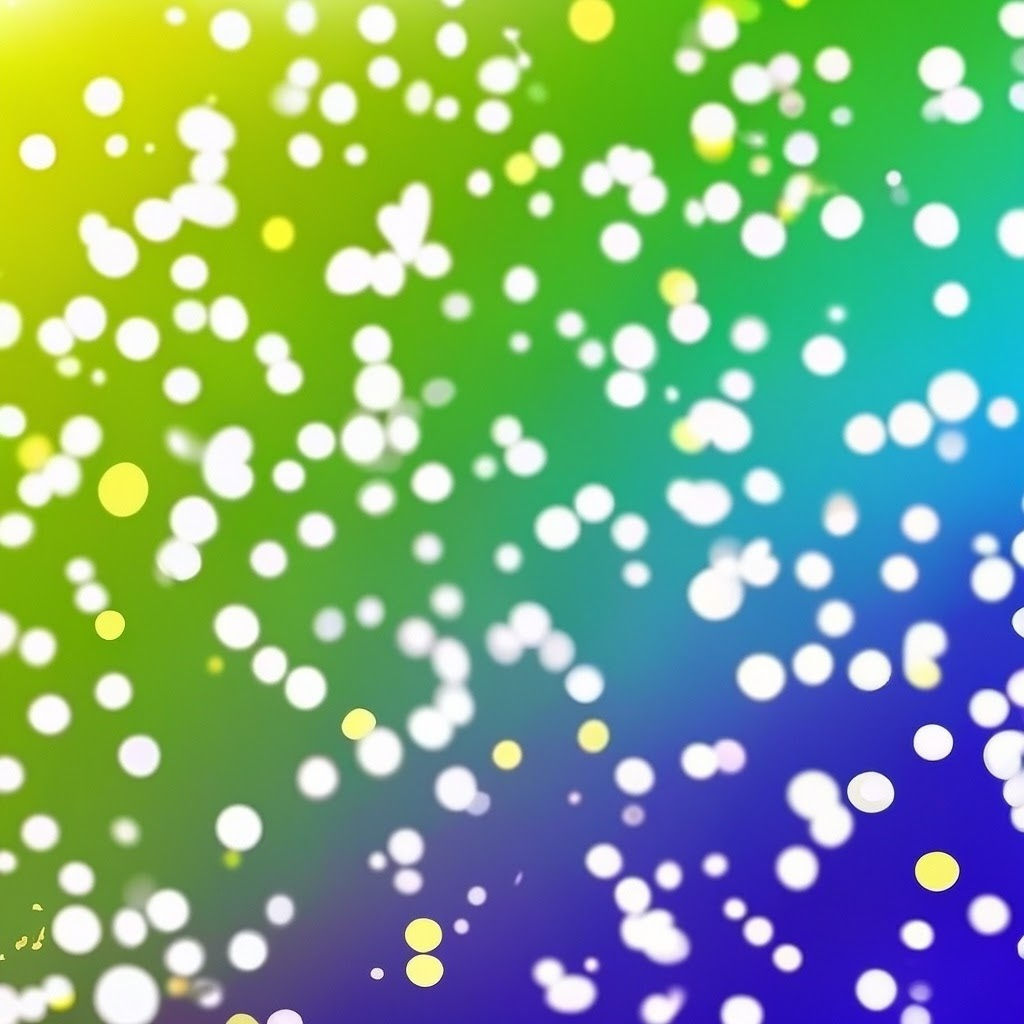

In [357]:
images[0].show()

#### Editing

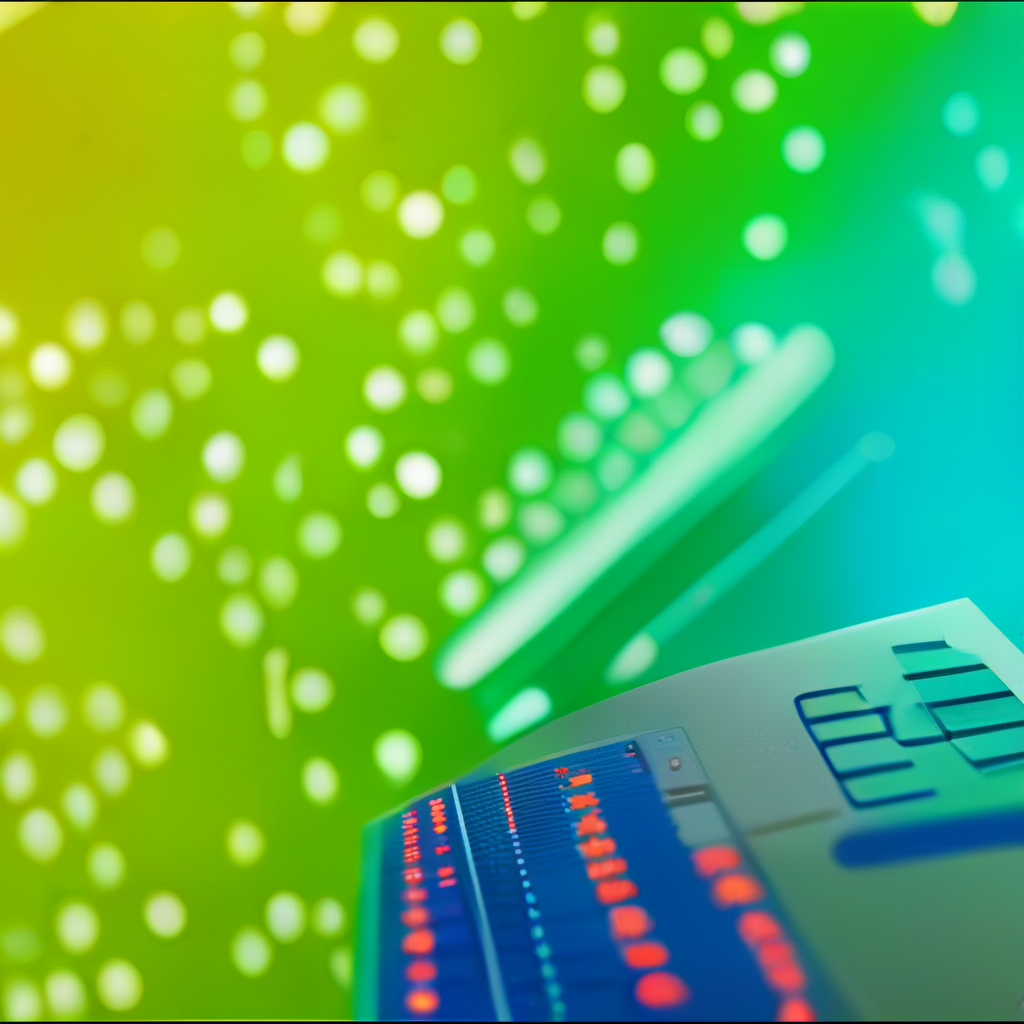

In [358]:
edited_image = model.edit_image(
    base_image = images[0],
    prompt = 'computer',
)
edited_image[0].show()

#### Upscale

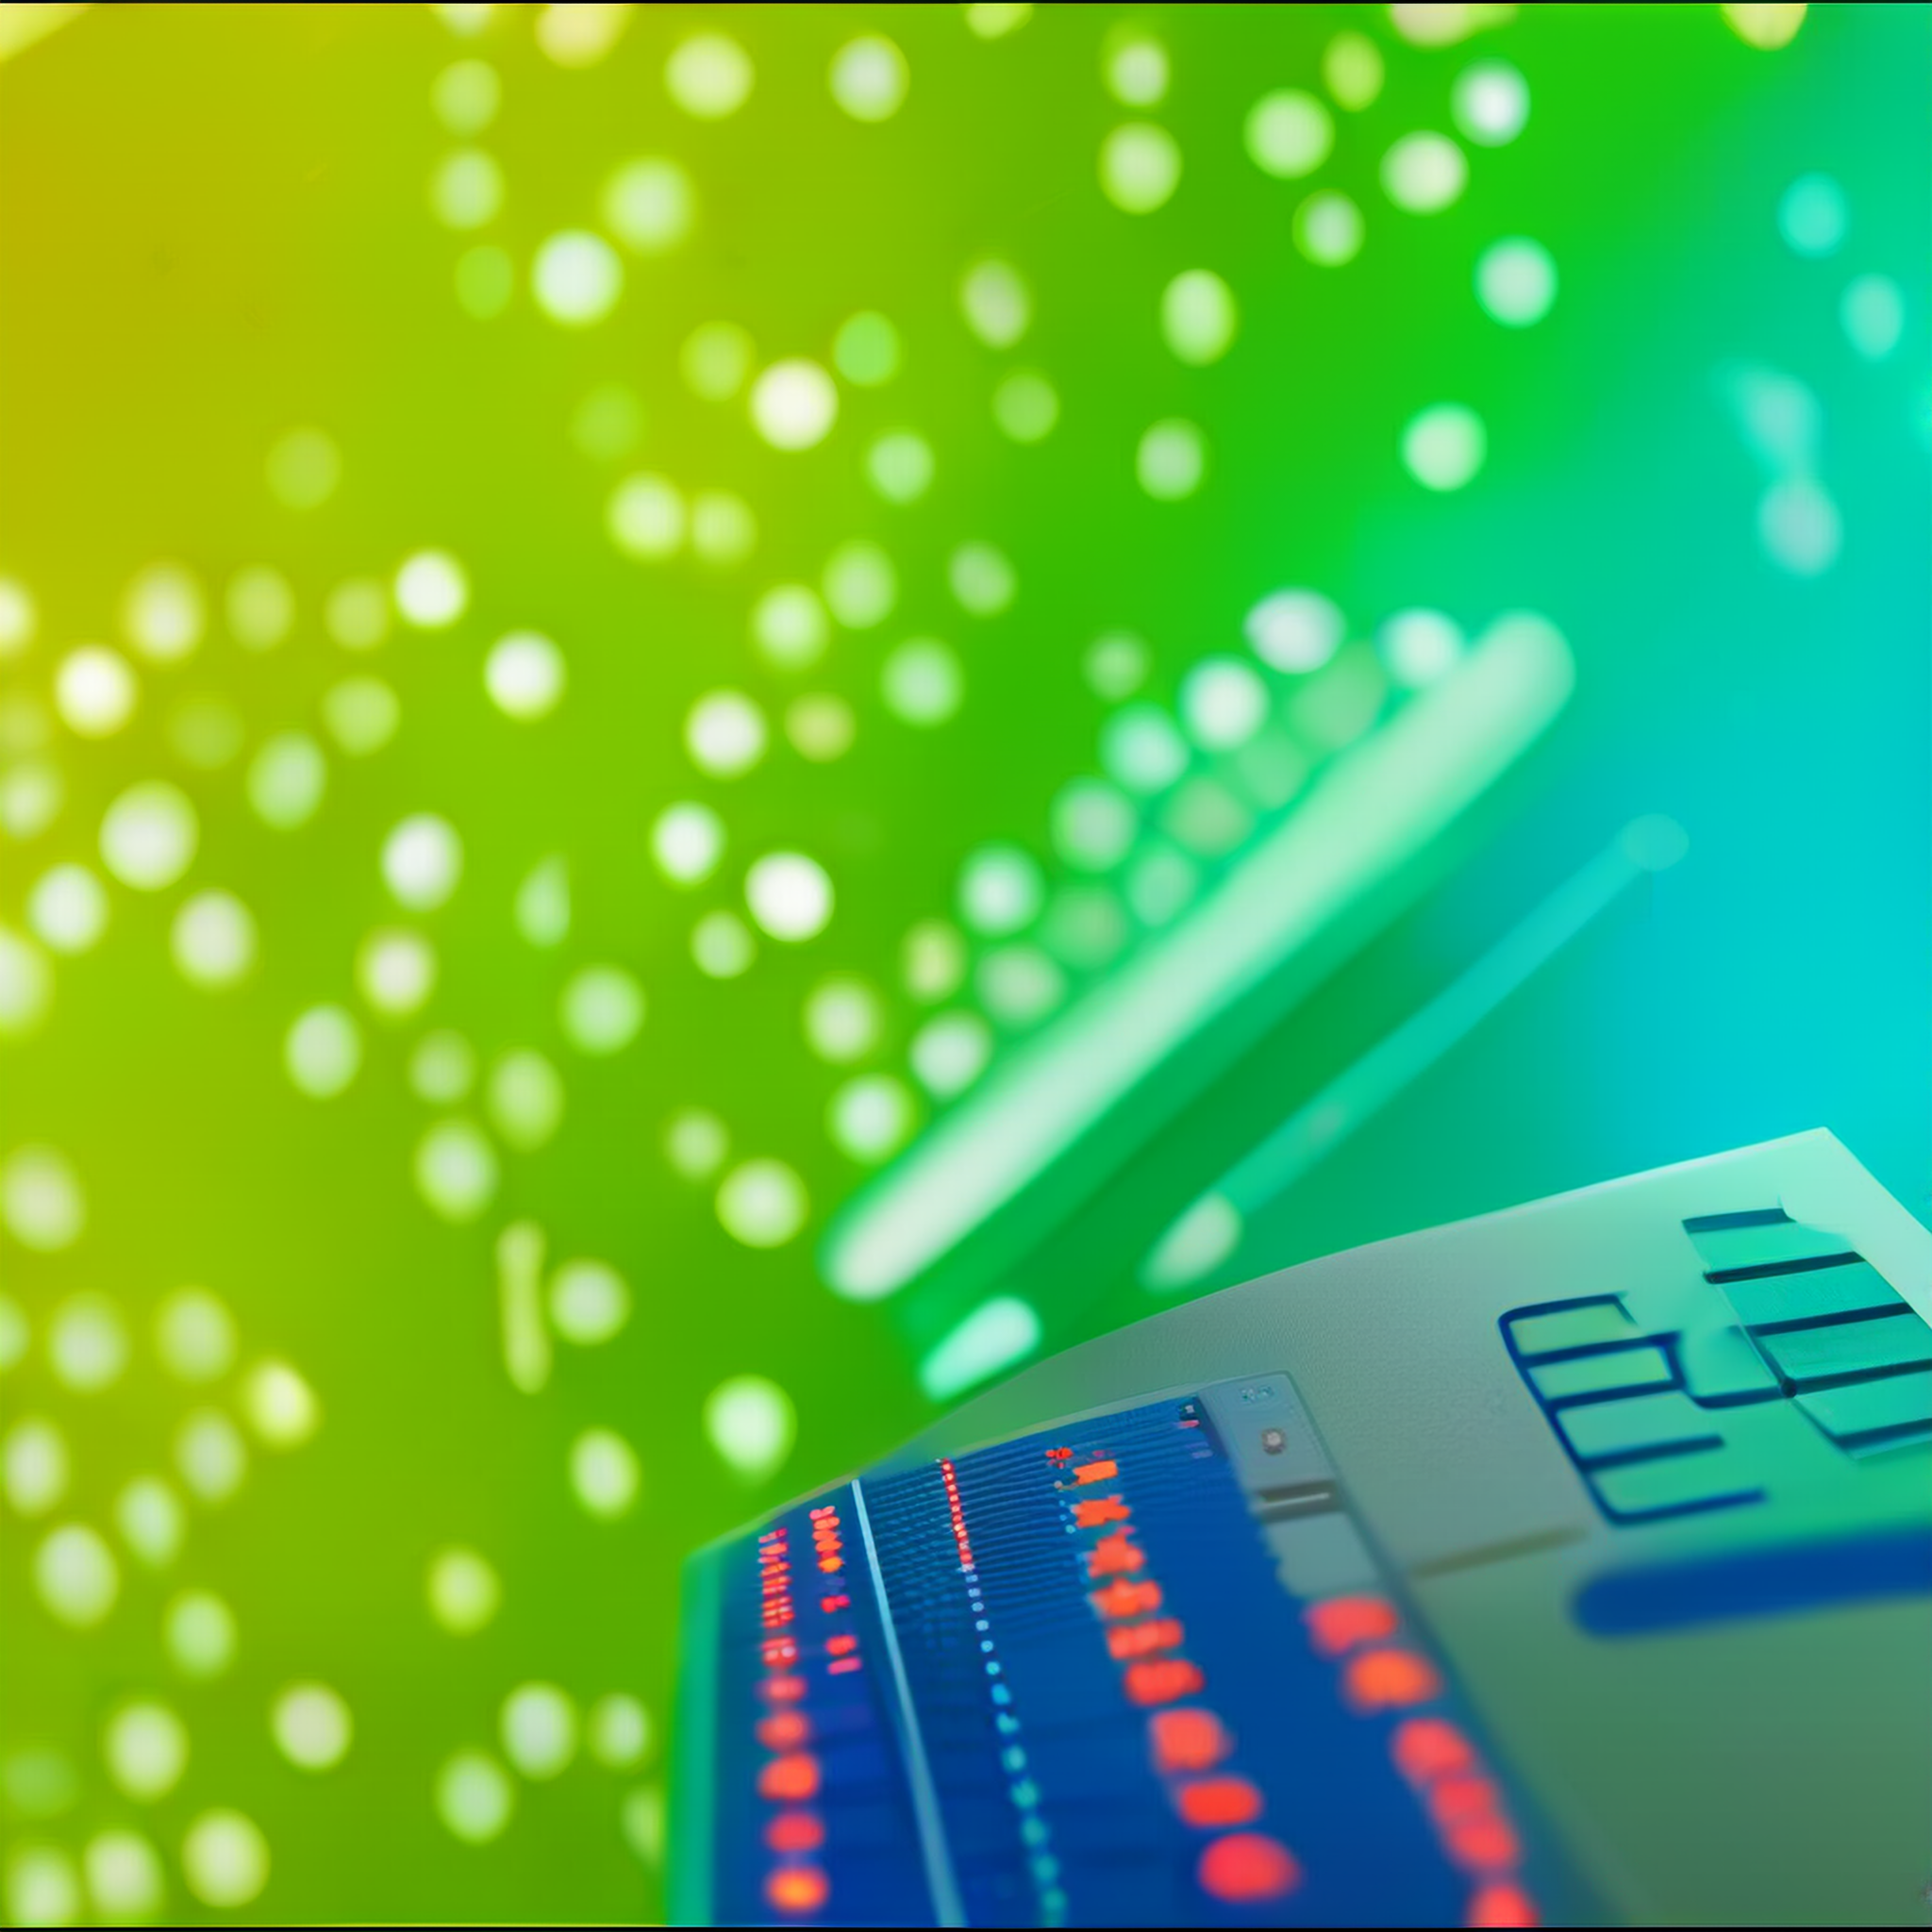

In [360]:
model.upscale_image(
    image = edited_image[0],
    new_size = 2048
).show()

<a id='async'></a>

---
## Async Predictions In Use:

An example of using the [vertexai.language_models.TextGenerationModel.predict_async()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.TextGenerationModel#vertexai_language_models_TextGenerationModel_predict_async) method:

In [44]:
import asyncio
import time

In [50]:
model = vertexai.language_models.TextGenerationModel.from_pretrained('text-bison')

In [403]:
prompts = [
    'What are the rules of baseball?',
    'What are the rules of football?',
    'What are the rules of hockey?',
    'What are the rules of basketball?',
    'What are the rules of soccer?'
]

---
### Make A Call

First, make the call to `.predict_async()`:

In [404]:
response = model.predict_async(prompts[0], stop_sequences = ['3)', '3.'])

In [405]:
type(response)

coroutine

Notice that the response is currently a coroutine.  It has not actually run yet.  Using `await` will run the coroutine and wait for the response:

In [406]:
response = await response

In [407]:
type(response)

vertexai.language_models.MultiCandidateTextGenerationResponse

Now, the response is the actual response from the model:

In [410]:
print(response.text)

 1) The object of the game is to score runs by hitting the ball and advancing around the bases.

2) A team scores a run when a player advances around all four bases and touches home plate.




Put this all together in a single call:

In [411]:
response = await model.predict_async(prompts[0], stop_sequences = ['3)', '3.'])
print(response.text)

 1) The object of the game is to score runs by hitting the ball and advancing around the bases.

2) A team scores a run when a player advances around all four bases and touches home plate.




---
### Make Concurrent Calls

In [416]:
responses = await asyncio.gather(*[model.predict_async(prompt, stop_sequences = ['3)', '3.']) for prompt in prompts])

In [417]:
for r, response in enumerate(responses):
    print(prompts[r])
    print(response.text.strip())
    print('\n---------------------------------------------------------------------------------------\n')

What are the rules of baseball?
1) The object of the game is to score runs by hitting the ball and advancing around the bases.

2) A team scores a run when a player advances around all four bases and touches home plate.

---------------------------------------------------------------------------------------

What are the rules of football?
1. **The object of the game is to score more goals than your opponent.** A goal is scored when the ball fully crosses the goal line between the posts and under the crossbar.
2. **Each team has 11 players on the field, including the goalkeeper.** The goalkeeper is the only player who is allowed to use their hands to touch the ball.

---------------------------------------------------------------------------------------

What are the rules of hockey?
Here are the basic rules of hockey:

1. **Object of the Game**: The objective of hockey is to score more goals than your opponent by hitting a small, hard puck into the opponent's net using a hockey stick.

---
### Function to Make Async Calls and Limit Concurrent Request:

This function sets up a limit to the concurrency (defaults to 10), and managed the input instances as concurrent request within the limit.  As written, it can still get a `ResourceExhausted: 429 Qouta exceeded ...` error because it does not try to limit the queries per minute.  More on that later in this workbook.

In [418]:
async def asyncTextGen(instances, limit_concur_request = 10):
    limit = asyncio.Semaphore(limit_concur_request)
    preds = [None] * len(instances)
    
    async def predictor(p):
        async with limit:
            if limit.locked():
                await asyncio.sleep(.01)
            pred = await model.predict_async(instances[p], stop_sequences = ['3)', '3.'])
        preds[p] = pred
        
    async def runner(instances):
        tasks = []
        for p in range(len(instances)):
            task = asyncio.create_task(predictor(p))
            tasks.append(task)
        results = await asyncio.gather(*tasks)
    
    start = time.perf_counter()
    await runner(instances)
    elapsed = time.perf_counter() - start
    print(f'{elapsed:0.5f} seconds')
    
    return preds

In [419]:
# do 1 at a time:
responses = await asyncTextGen(prompts, 1)

10.67207 seconds


In [420]:
for r, response in enumerate(responses):
    print(prompts[r])
    print(response.text.strip())
    print('\n---------------------------------------------------------------------------------------\n')

What are the rules of baseball?
1) The object of the game is to score runs by hitting the ball and advancing around the bases.

2) A team scores a run when a player advances around all four bases and touches home plate.

---------------------------------------------------------------------------------------

What are the rules of football?
1. **The object of the game is to score more goals than your opponent.** A goal is scored when the ball fully crosses the goal line between the posts and under the crossbar.
2. **Each team has 11 players on the field, including the goalkeeper.** The goalkeeper is the only player who is allowed to use their hands to touch the ball.

---------------------------------------------------------------------------------------

What are the rules of hockey?
Here are the basic rules of hockey:

1. The object of the game is to score more goals than your opponent by hitting a small, hard puck into the opponent's net using a hockey stick.
2. Each team has six pla

In [423]:
# do 2 at a time:
responses = await asyncTextGen(prompts, 2)

5.97398 seconds


In [422]:
# do 5 at a time:
responses = await asyncTextGen(prompts, 5)

2.09637 seconds


---
##  Handling Limits: Query Per Minute

There are [quotas and limits](https://cloud.google.com/vertex-ai/docs/quotas) that restrict the projects use of models, specifically the number of request per minutes.  Across all models in a project there is a very high limit for predictions per minute in a region (30,000).  Generative AI models have much lower limits by default. Request can be made to increase these limits: [Quota increases](https://cloud.google.com/vertex-ai/docs/quotas#quota_increases).

In application design it is not always possible to control all applications trying to make request of a resource at the minute level.  Techniques are needed to detect quota exahaustion and retry after waiting.  The section below shows using asynchronous request, as covered above, as well as tripping the request qouta and overcoming it through waiting:

In [424]:
import asyncio

In [440]:
model_name = 'text-bison'
known_limit = 60
prompt = 'What are the rules of baseball?'

In [441]:
model = vertexai.language_models.TextGenerationModel.from_pretrained(model_name)

### Test Within Limit:

In [427]:
responses = await asyncio.gather(*[model.predict_async(prompt) for i in range(known_limit)])

Check that all responses are the same:

In [460]:
list(set([response.text[0:30] for response in responses]))

[' 1) The object of the game is ']

### Exceed Limit:

Running the cell below (uncomment to test it), will lead to a quota exhaustion error:

In [437]:
#responses = await asyncio.gather(*[model.predict_async(prompt) for i in range(known_limit*2)])

```
---------------------------------------------------------------------------
AioRpcError                               Traceback (most recent call last)
File /opt/conda/lib/python3.10/site-packages/google/api_core/grpc_helpers_async.py:81, in _WrappedUnaryResponseMixin.__await__(self)
     80 try:
---> 81     response = yield from self._call.__await__()
     82     return response

File /opt/conda/lib/python3.10/site-packages/grpc/aio/_call.py:290, in _UnaryResponseMixin.__await__(self)
    289     else:
--> 290         raise _create_rpc_error(self._cython_call._initial_metadata,
    291                                 self._cython_call._status)
    292 else:

AioRpcError: <AioRpcError of RPC that terminated with:
	status = StatusCode.RESOURCE_EXHAUSTED
	details = "Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas."
	debug_error_string = "UNKNOWN:Error received from peer ipv4:74.125.70.95:443 {created_time:"2023-10-12T21:05:26.756525361+00:00", grpc_status:8, grpc_message:"Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas."}"
>

The above exception was the direct cause of the following exception:

ResourceExhausted                         Traceback (most recent call last)
Cell In[436], line 1
----> 1 responses = await asyncio.gather(*[model.predict_async(prompt) for i in range(known_limit*2)])

File /opt/conda/lib/python3.10/site-packages/vertexai/language_models/_language_models.py:816, in _TextGenerationModel.predict_async(self, prompt, max_output_tokens, temperature, top_k, top_p, stop_sequences, candidate_count)
    792 """Asynchronously gets model response for a single prompt.
    793 
    794 Args:
   (...)
    804     A `MultiCandidateTextGenerationResponse` object that contains the text produced by the model.
    805 """
    806 prediction_request = _create_text_generation_prediction_request(
    807     prompt=prompt,
    808     max_output_tokens=max_output_tokens,
   (...)
    813     candidate_count=candidate_count,
    814 )
--> 816 prediction_response = await self._endpoint.predict_async(
    817     instances=[prediction_request.instance],
    818     parameters=prediction_request.parameters,
    819 )
    821 return _parse_text_generation_model_multi_candidate_response(prediction_response)

File /opt/conda/lib/python3.10/site-packages/google/cloud/aiplatform/models.py:1655, in Endpoint.predict_async(self, instances, parameters, timeout)
   1620 """Make an asynchronous prediction against this Endpoint.
   1621 Example usage:
   1622     ```
   (...)
   1651         Prediction with returned predictions and Model ID.
   1652 """
   1653 self.wait()
-> 1655 prediction_response = await self._prediction_async_client.predict(
   1656     endpoint=self._gca_resource.name,
   1657     instances=instances,
   1658     parameters=parameters,
   1659     timeout=timeout,
   1660 )
   1662 return Prediction(
   1663     predictions=[
   1664         json_format.MessageToDict(item)
   (...)
   1669     model_resource_name=prediction_response.model,
   1670 )

File /opt/conda/lib/python3.10/site-packages/google/cloud/aiplatform_v1/services/prediction_service/async_client.py:358, in PredictionServiceAsyncClient.predict(self, request, endpoint, instances, parameters, retry, timeout, metadata)
    353 metadata = tuple(metadata) + (
    354     gapic_v1.routing_header.to_grpc_metadata((("endpoint", request.endpoint),)),
    355 )
    357 # Send the request.
--> 358 response = await rpc(
    359     request,
    360     retry=retry,
    361     timeout=timeout,
    362     metadata=metadata,
    363 )
    365 # Done; return the response.
    366 return response

File /opt/conda/lib/python3.10/site-packages/google/api_core/grpc_helpers_async.py:84, in _WrappedUnaryResponseMixin.__await__(self)
     82     return response
     83 except grpc.RpcError as rpc_error:
---> 84     raise exceptions.from_grpc_error(rpc_error) from rpc_error

ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.
```

### Detect Limit and Retry:

Recall the function above that managed concurrent requests and modify it to detect the errors and retry with graduated backoff intervals (exponential backoff):

In [471]:
async def asyncTextGen(instances, limit_concur_request = 10):
    limit = asyncio.Semaphore(limit_concur_request)
    preds = [None] * len(instances)
    
    async def predictor(p):
        async with limit:
            if limit.locked():
                await asyncio.sleep(.01)
            ######## MODIFY HERE TO DETECT ERRORS AND RETRY ######################################################################
            fail = True
            counter = 0
            while fail and counter <= 20:
                try:
                    pred = await model.predict_async(instances[p], stop_sequences = ['3)', '3.'])
                    fail = False
                    counter = 0
                except:
                    counter += 1
                    await asyncio.sleep(2^(min(counter, 6) - 1))
            if fail:
                pred = 'Failed'
            ######################################################################################################################
        preds[p] = pred
        
    async def runner(instances):
        tasks = []
        for p in range(len(instances)):
            task = asyncio.create_task(predictor(p))
            tasks.append(task)
        results = await asyncio.gather(*tasks)
    
    start = time.perf_counter()
    await runner(instances)
    elapsed = time.perf_counter() - start
    print(f'{elapsed:0.5f} seconds')
    
    return preds

In [472]:
min(2, 5)

2

#### Try Half of known_limit:

In [473]:
instances = [prompt] * int(known_limit/2)
len(instances)

30

In [474]:
# 30 concurrent channels managing instances:
responses = await asyncTextGen(instances, 30)

4.96891 seconds


Check that all responses are the same (no failures):

In [475]:
list(set([response.text[0:30] for response in responses]))

[' 1) The object of the game is ']

#### Try all of known_limit:

Wait a minute before proceeding to clear the rate limit.  This assumes that this is the only application in the project requesting predictions from this model.

In [476]:
await asyncio.sleep(60)

In [477]:
instances = [prompt] * known_limit
len(instances)

60

In [478]:
# 30 concurrent channels managing instances:
responses = await asyncTextGen(instances, 30)

5.98980 seconds


Check that all responses are the same (no failures):

In [479]:
list(set([response.text[0:30] for response in responses]))

[' 1) The object of the game is ']

#### Try 2 X known_limit:

Wait a minute before proceeding to clear the rate limit.  This assumes that this is the only application in the project requesting predictions from this model.

In [480]:
await asyncio.sleep(60)

In [481]:
instances = [prompt] * 2 * known_limit
len(instances)

120

In [482]:
# 30 concurrent channels managing instances:
responses = await asyncTextGen(instances, 30)

55.40182 seconds


Check that all responses are the same (no failures):

In [483]:
list(set([response.text[0:30] for response in responses]))

[' 1) The object of the game is ']

**NOTES**

All the predictions are successful, eventually, and return the expected response.  The timing is almost 1 minute longer than the previous try that stayed within the limit.  This reflect time spent waiting during the exponential backoff that managed the request until enough time passed and the quota could be restored.

#### Try 4 X known_limit:

Wait a minute before proceeding to clear the rate limit.  This assumes that this is the only application in the project requesting predictions from this model.

In [484]:
await asyncio.sleep(60)

In [485]:
instances = [prompt] * 4 * known_limit
len(instances)

240

In [486]:
# 30 concurrent channels managing instances:
responses = await asyncTextGen(instances, 30)

182.56571 seconds


Check that all responses are the same (no failures):

In [487]:
list(set([response.text[0:30] for response in responses]))

[' 1) The object of the game is ']

**NOTES**

All the predictions are successful, eventually, and return the expected response.  The timing is almost 3 minutes longer than the attmpet that stayed within the limit.  This reflects time spent waiting during the exponential backoff that managed the requests until more than a minute has passed and the quota could be restored - and it did this for nearly 3 full minutes to manage 4X the limit.